# Astrometric analysis with ePSF

## Importing some modules

In [1]:
import copy, warnings
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
from astropy.modeling import models, fitting
from astropy.nddata import NDData
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.visualization import simple_norm
from photutils.background import MMMBackground
from photutils.detection import find_peaks
from photutils.psf import EPSFBuilder, extract_stars

/Users/dkawata/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Reading a fits file

In [27]:
hdu = pf.open("img_ver1_1_A.fits")[0]
data = hdu.data.astype(np.float32)
norm = simple_norm(data, 'sqrt', percent=99.)

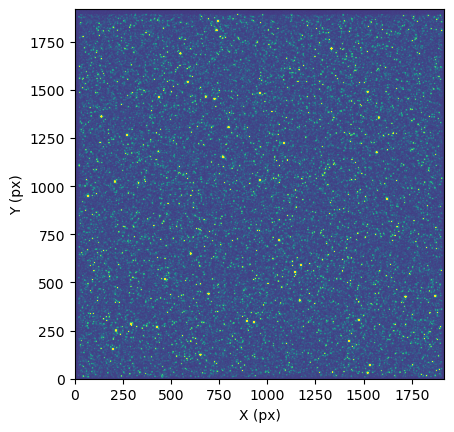

In [3]:
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

In [4]:
np.shape(data)

(1920, 1920)

### Find Peaks

In [5]:
# Finding peaks.
#    mag = 12.0       # Object magnitude.
mag = 11.0
threshold = 3000.*10.**((mag-12.0)/(-2.5))
peaks_tbl = find_peaks(data, threshold=threshold)

In [6]:
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
   240     15       8067
  1824     17      13520
  1796     24       8772
   662     31       8031
  1518     33      91775
  1269     34       9432
   336     36       8471
   ...    ...        ...
  1397   1858      10885
   429   1862       9242
  1877   1866      10141
  1437   1868       9408
   692   1869       9691
   820   1869       7620
   844   1891       9293
Length = 523 rows


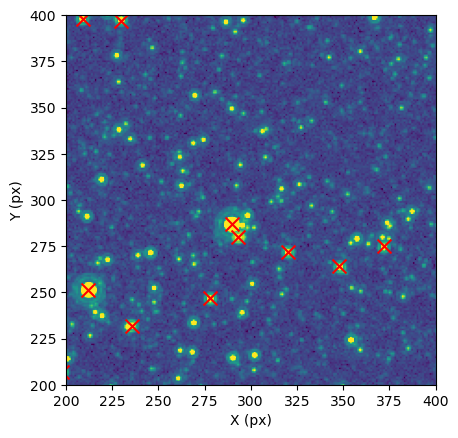

In [18]:
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.scatter(peaks_tbl['x_peak'], peaks_tbl['y_peak'], s=100, c='red', marker='x')
plt.xlim(200, 400)
plt.ylim(200, 400)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

### Read input stellar data

In [16]:
# Loading stellar-plate data.
original = np.loadtxt("galcen_star_plate.csv",skiprows=1,delimiter=",")

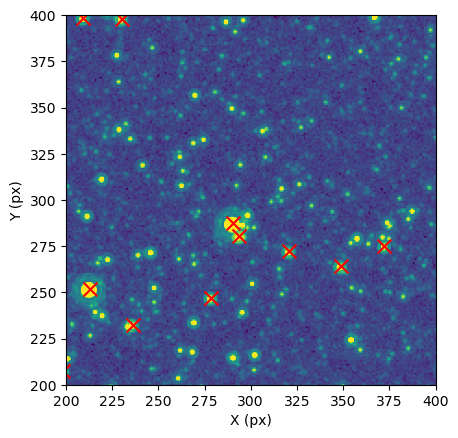

In [17]:
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
maglimit = 12.5
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.xlim(200, 400)
plt.ylim(200, 400)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.show()

In [19]:
# Removing detections near edge.
mask_size = 25 
hsize = (mask_size - 1) / 2
x = peaks_tbl['x_peak'] 
y = peaks_tbl['y_peak'] 
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
            (y > hsize) & (y < (data.shape[0] -1 - hsize)))
stars_tbl = Table()
stars_tbl['x'] = x[mask]
stars_tbl['y'] = y[mask]
print(stars_tbl)

 x    y  
---- ----
 240   15
1824   17
1796   24
 662   31
1518   33
1269   34
 336   36
 ...  ...
1397 1858
 429 1862
1877 1866
1437 1868
 692 1869
 820 1869
 844 1891
Length = 523 rows


Text(0, 0.5, 'Y (px)')

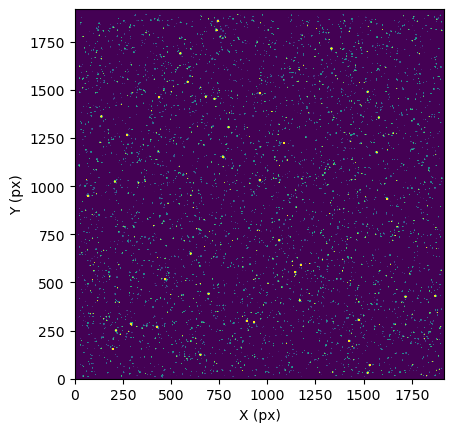

In [20]:
# Subtracting background.
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.)  
image = copy.deepcopy(data)
data -= mean_val
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')

(1920, 1920)


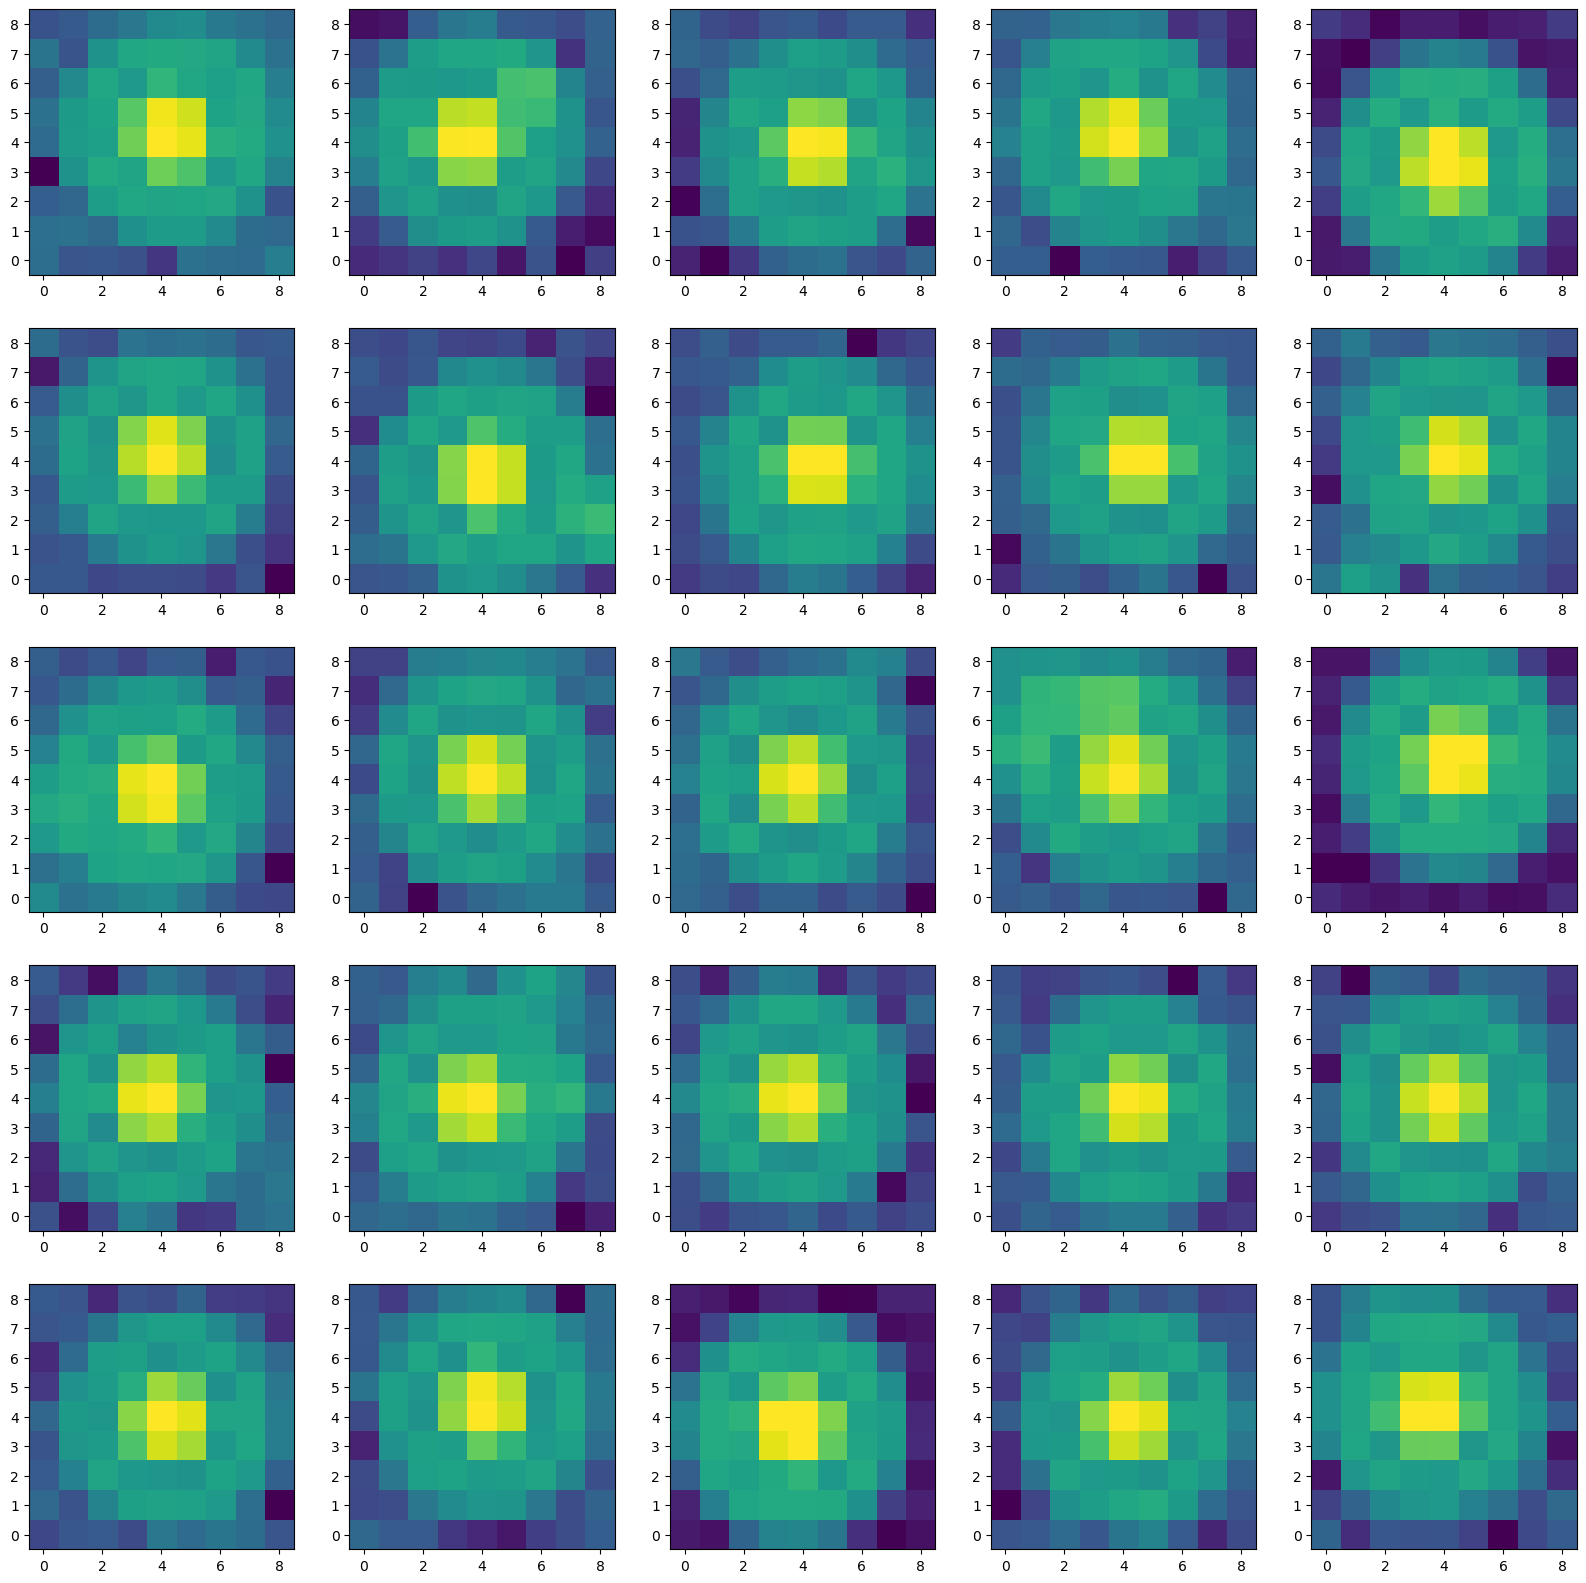

In [21]:
# Extracting stellar images.
ext_size  = 9  
nddata = NDData(data=data)
print(nddata.data.shape)
stars = extract_stars(nddata, stars_tbl, size=ext_size)
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), squeeze=True)
ax = ax.ravel()
for i in range(nrows*ncols):
    norm = simple_norm(stars[i], 'log', percent=99.)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
plt.show()

### Makind ePSF

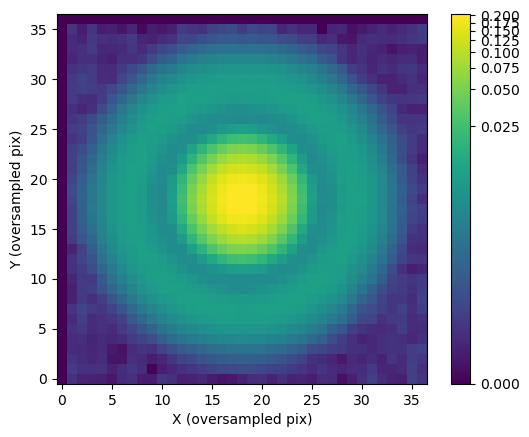

In [22]:
# Making ePSF.
n_oversample = 4 # Number of oversampling for ePSF.
n_maxiter    = 3 # Max. number of iteration for making ePSF.
norm_radius  = 5.5 # Number of undersampled pixels which determines the radius for flux normalization of ePSF.
recentering_boxsize = 5 #  Number of undersampled pixels which determines the box size for ePSF recentering calculation.

epsf_builder = EPSFBuilder(oversampling=n_oversample,
                           maxiters=n_maxiter, progress_bar=False,
                           norm_radius=norm_radius, recentering_boxsize=recentering_boxsize,
                           center_accuracy=0.001)
epsf, fitted_stars = epsf_builder(stars)
norm = simple_norm(epsf.data, 'log', percent=99.)
    
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.xlabel('X (oversampled pix)')
plt.ylabel('Y (oversampled pix)')
plt.colorbar()
plt.show()

In [79]:
print(' centre_flat =', fitted_stars.center_flat, np.shape(fitted_stars.center_flat))

 centre_flat = [[ 240.31802937   15.36219494]
 [1823.53103691   17.14332527]
 [1796.41862068   23.86013165]
 ...
 [ 691.86982269 1868.53223253]
 [ 819.72896937 1868.52958578]
 [ 843.88213395 1891.20756812]] (523, 2)


number of stars brighter than  12.5 = 543


(0.0, 250.0)

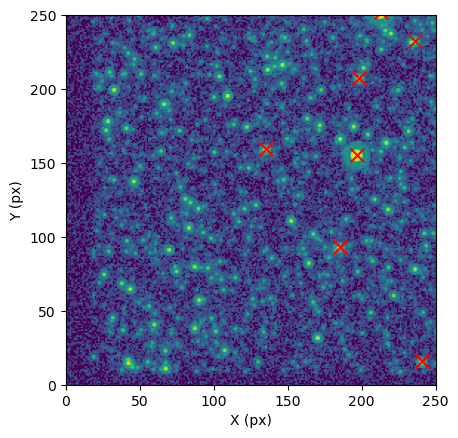

In [90]:
# Subtracting background.
maglimit = 12.5
print('number of stars brighter than ', maglimit, '=', len(original[original[:,6]<maglimit, 2]))
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim(0, 250)
plt.ylim(0, 250)


Text(0, 0.5, 'Y (px)')

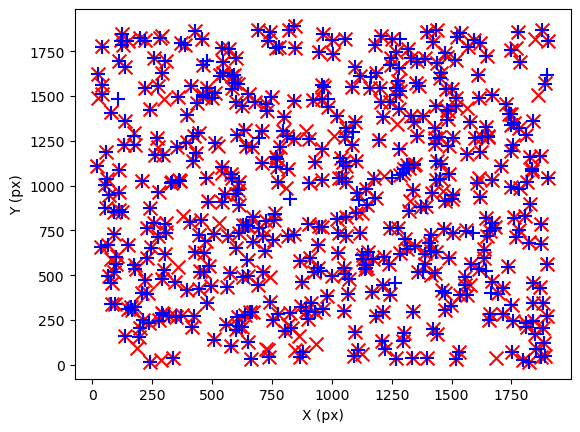

In [51]:
plt.scatter(original[original[:, 6]<maglimit, 3]-1, original[original[:,6]<maglimit, 2]-1, s=100, c='red', marker='x')
plt.scatter(fitted_stars.center_flat[:, 0], fitted_stars.center_flat[:, 1],  s=100, c='blue', marker='+')
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
# plt.xlim(200, 300)
# plt.ylim(200, 300)

(2006, 7)
 N fitted stars= (523, 2) 523
 fitted_stars.center_flat (2,)
 star  22  min dist = 0.7760968059577762 9.377989669300002


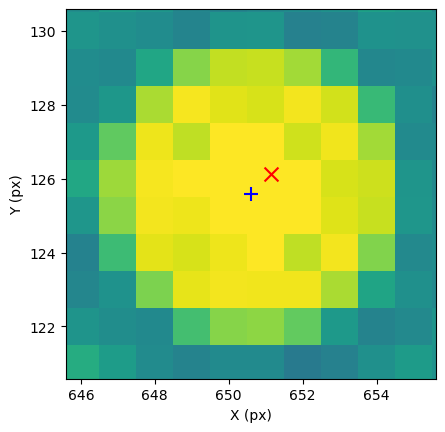

 star  64  min dist = 0.8019643814458921 9.377989669300002


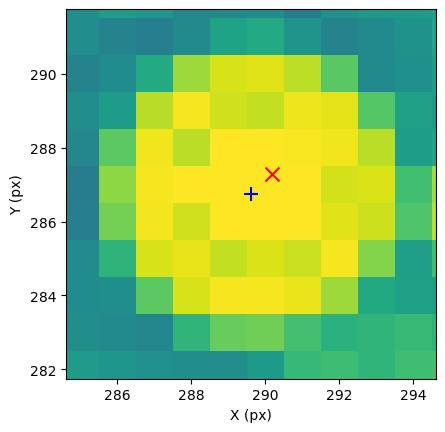

 star  104  min dist = 0.8179293006521976 9.377989669300002


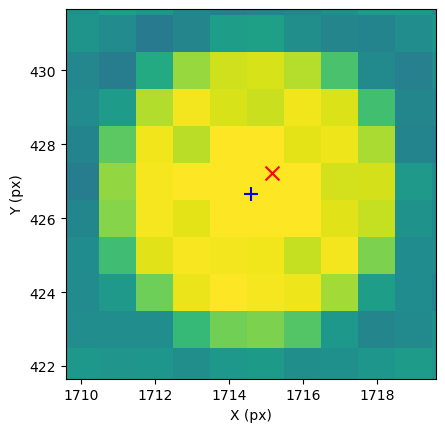

 star  283  min dist = 0.7965646153037015 9.377989669300002


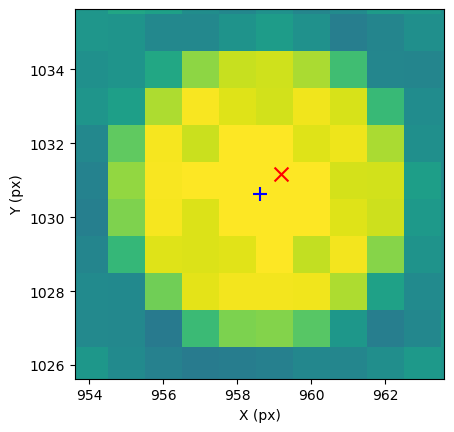

 star  320  min dist = 0.7971029437056826 9.377989669300002


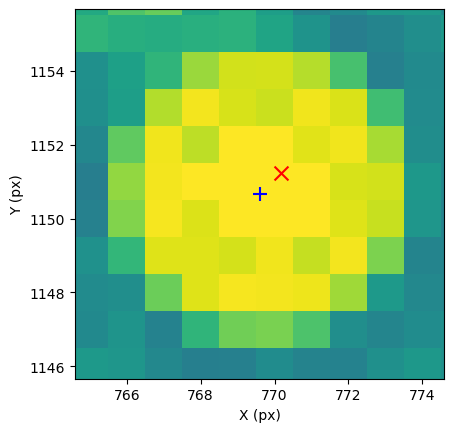

 star  327  min dist = 0.82311388537123 9.377989669300002


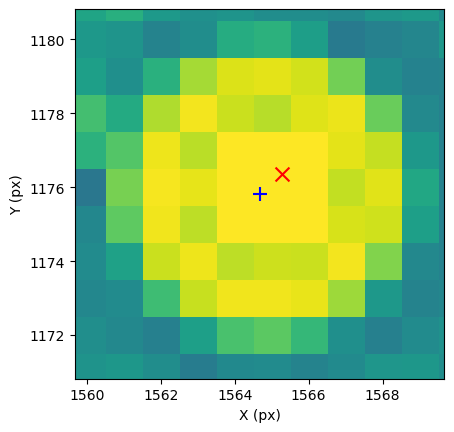

 number of stars brighter than  13.5  in the list = 523


In [68]:
# Cross-matching the data.
xc_array = []
maglim_o = maglimit+1.0
# search stars only for brighter stars
stars_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_list))

# for loop for fitted stars
nfitted_stars = len(fitted_stars.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars.center_flat), nfitted_stars)
print(' fitted_stars.center_flat', np.shape(fitted_stars.center_flat[0]))
for i in range(nfitted_stars):
    xdiff = fitted_stars.center_flat[i, 0]-stars_list[:, 3]+1.0
    ydiff = fitted_stars.center_flat[i, 1]-stars_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
    # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
    xc_array.append([stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                             fitted_stars.center_flat[i, 0],
                             fitted_stars.center_flat[i, 1]])
    if dist2[mindx]>0.6: 
        print(' star ', i, ' min dist =', np.sqrt(dist2[mindx]), stars_list[mindx, 6])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<maglim_o, 3]-1, original[original[:,6]<maglim_o, 2]-1, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(fitted_stars.center_flat[i, 0]-5.0, fitted_stars.center_flat[i, 0]+5.0)
        plt.ylim(fitted_stars.center_flat[i, 1]-5.0, fitted_stars.center_flat[i, 1]+5.0)
        plt.show()
xc_array = np.array(xc_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_array))

In [92]:
# excluding bright stars
xc_array = []
maglim_o = maglimit+1.0
maglim_bright = 9.5
# search stars only for brighter stars
stars_list = original[original[:, 6] < maglim_o]
print(np.shape(stars_list))

# for loop for fitted stars
nfitted_stars = len(fitted_stars.center_flat[:, 0])
print(' N fitted stars=', np.shape(fitted_stars.center_flat), nfitted_stars)
print(' fitted_stars.center_flat', np.shape(fitted_stars.center_flat[0]))
for i in range(nfitted_stars):
    xdiff = fitted_stars.center_flat[i, 0]-stars_list[:, 3]+1.0
    ydiff = fitted_stars.center_flat[i, 1]-stars_list[:, 2]+1.0
    dist2 = xdiff**2+ydiff**2
    # closest
    mindx = np.argmin(dist2)
    if stars_list[mindx, 6]> maglim_bright:
        # print(' indx, dist, x, y s, f=', mindx, dist2[mindx], o[3]-1.0, o[2]-1.0, fitted_stars.center_flat[mindx])
        # print(dist2[mindx], stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,fitted_stars.center_flat[i, 0], fitted_stars.center_flat[i, 1])
        xc_array.append([stars_list[mindx, 3]-1.,stars_list[mindx, 2]-1.,      # 1-origin -> 0-origin
                                 fitted_stars.center_flat[i, 0],
                                 fitted_stars.center_flat[i, 1]])

xc_array = np.array(xc_array)
print(' number of stars brighter than ', maglim_o, ' in the list =', len(xc_array))

(2006, 7)
 N fitted stars= (523, 2) 523
 fitted_stars.center_flat (2,)
 number of stars brighter than  13.5  in the list = 481


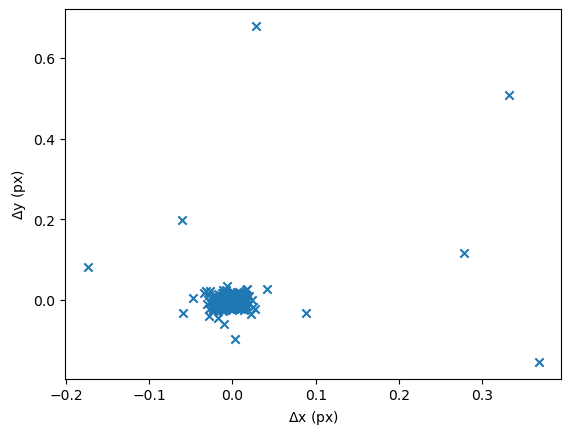

In [94]:
# Making dx/dy data.
dx = xc_array[:,2] - xc_array[:,0]
dy = xc_array[:,3] - xc_array[:,1]
dx = dx - np.mean(dx)
dy = dy - np.mean(dy)
plt.scatter(dx, dy, marker='x')
plt.xlabel('$\Delta$x (px)')
plt.ylabel('$\Delta$y (px)')
# plt.xlim([-0.01,0.01])
# plt.ylim([-0.01,0.01])
plt.show()

 star  144  dist= 0.6798508484688406


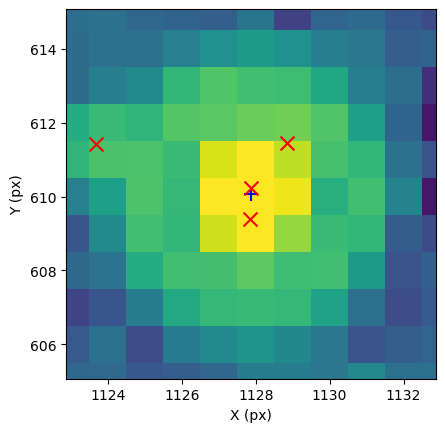

 star  205  dist= 0.6075495701370794


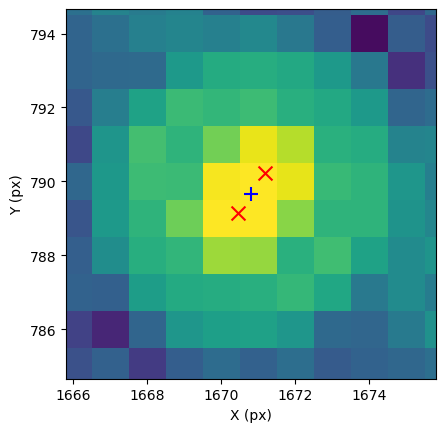

 star  408  dist= 0.39866581210949603


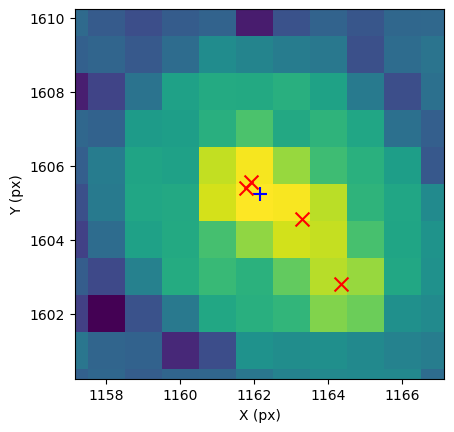

 star  430  dist= 0.30216511090005427


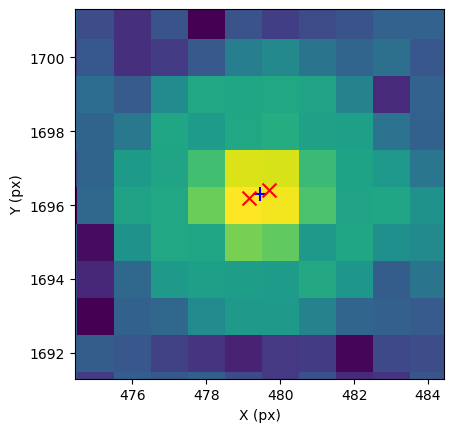

In [114]:
dx = xc_array[:,2] - xc_array[:,0]
dy = xc_array[:,3] - xc_array[:,1]
dx0 = dx - np.mean(dx)
dy0 = dy - np.mean(dy)
dist = np.sqrt(dx0**2+dy0**2)
dx_mean =  np.mean(dx)
dy_mean =  np.mean(dy)
for i in range(len(dist)):
    if dist[i]>0.3: 
        print(' star ', i, ' dist=', dist[i])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(xc_array[i,2], xc_array[i,3], s=100, c='blue', marker='+')
        plt.scatter(original[original[:, 6]<15.0, 3]-1+dx_mean, original[original[:,6]<15.0, 2]-1+dy_mean, s=100, c='red', marker='x')
        # plt.scatter(xc_array[i,0]+dx_mean, xc_array[i,1]+dx_mean, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(xc_array[i,2]-5.0, xc_array[i,2]+5.0)
        plt.ylim(xc_array[i,3]-5.0,xc_array[i,3]+5.0)
        plt.show()

 dx and dy mean =  -0.4891252514721715 -0.47407530009015025
 star  0  dist= 0.0010908781221409289


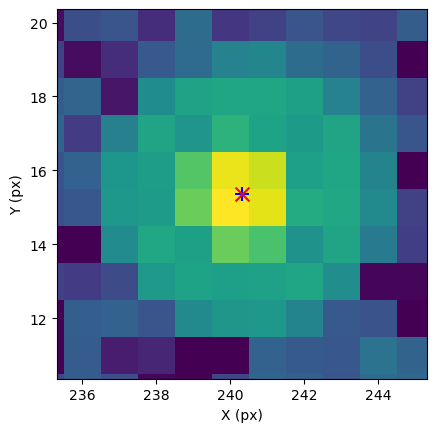

 star  19  dist= 0.0003835865683141741


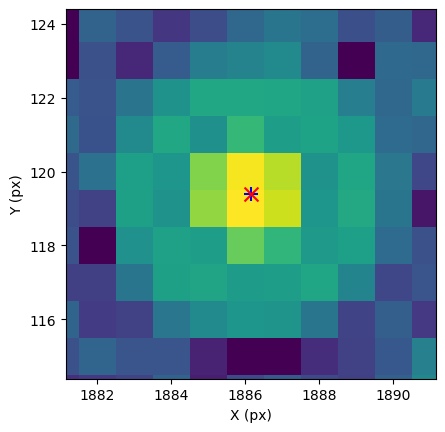

 star  31  dist= 0.0019145991821260006


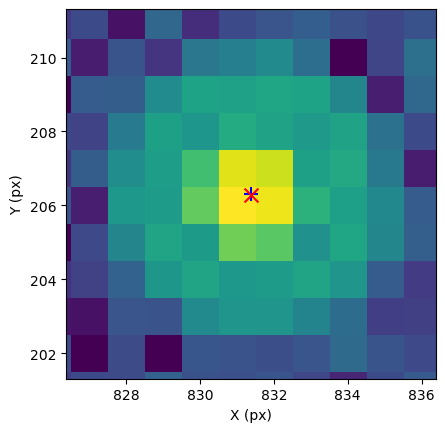

 star  32  dist= 0.001191290080459979


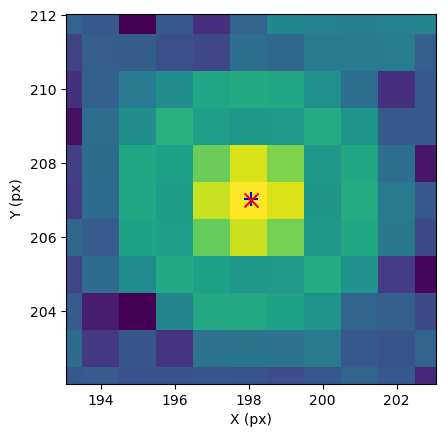

 star  84  dist= 0.0011325250049838613


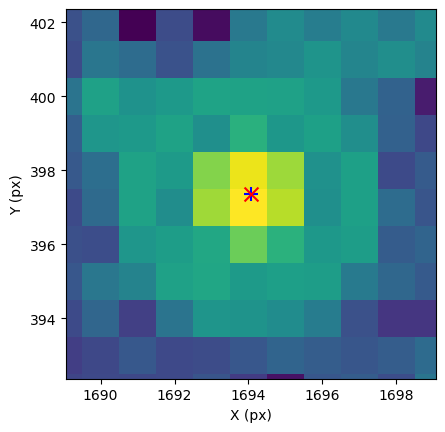

 star  93  dist= 0.001660437818310987


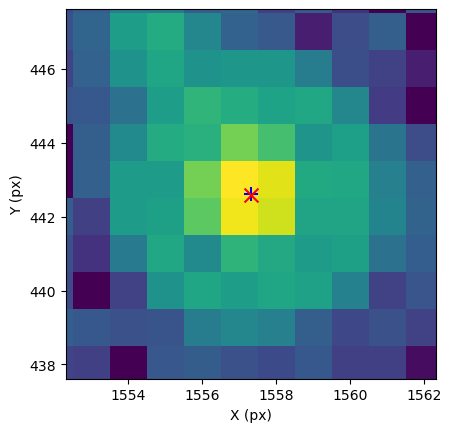

 star  107  dist= 0.001723964124167997


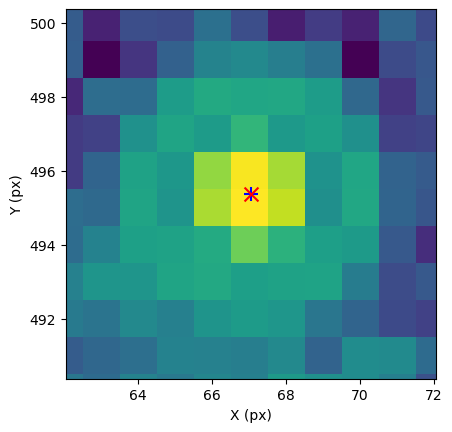

 star  182  dist= 0.002660438297290521


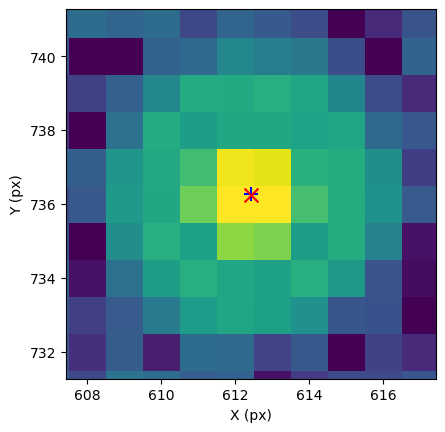

 star  215  dist= 0.0014540939143943428


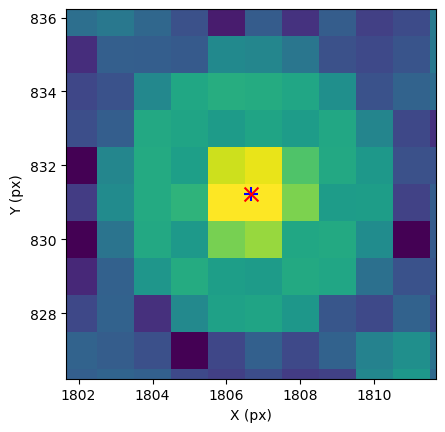

 star  229  dist= 0.0028046299696740215


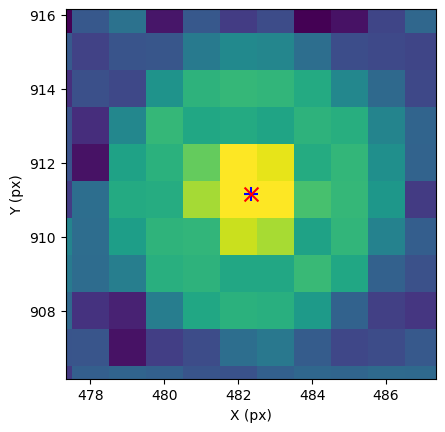

 star  233  dist= 0.001786195676990907


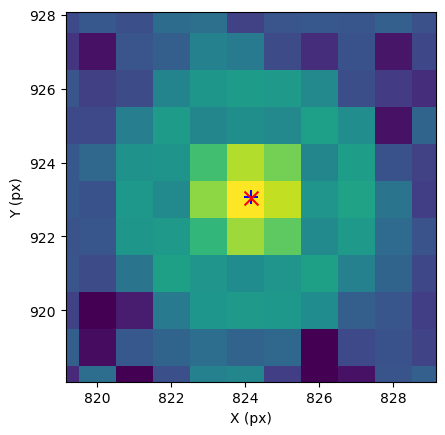

 star  245  dist= 0.0022476884518044535


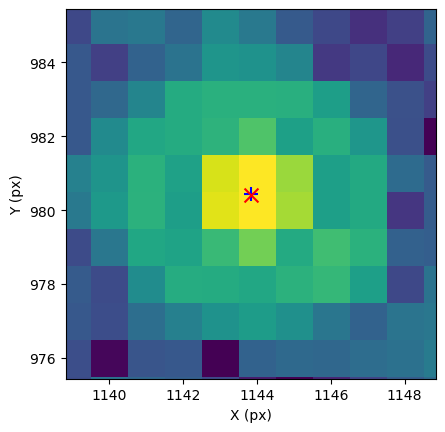

 star  262  dist= 0.0015016071604215288


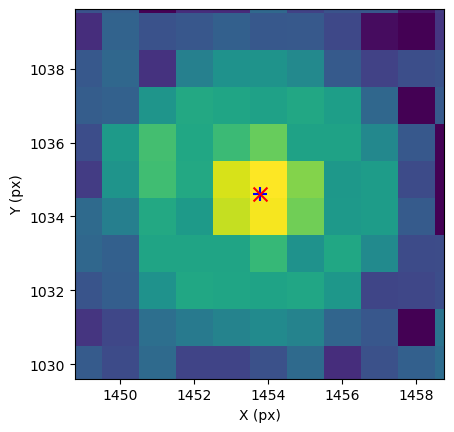

 star  266  dist= 0.0022352651483629


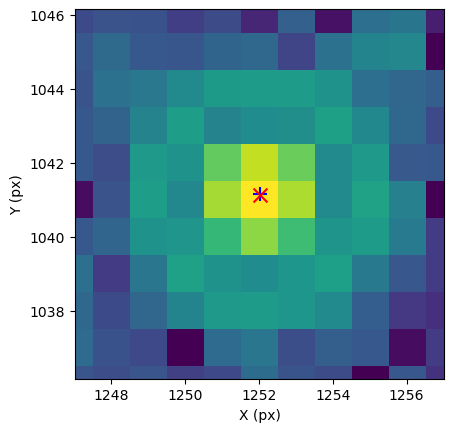

 star  272  dist= 0.002910860281384969


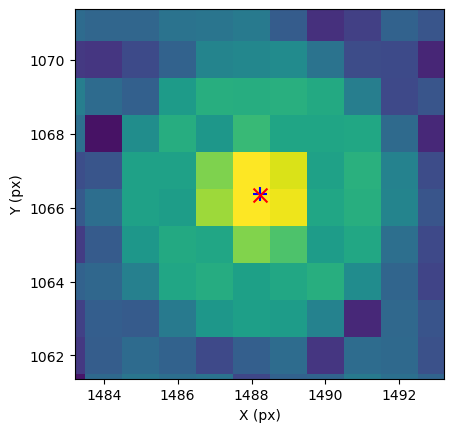

 star  275  dist= 0.0013413841981267647


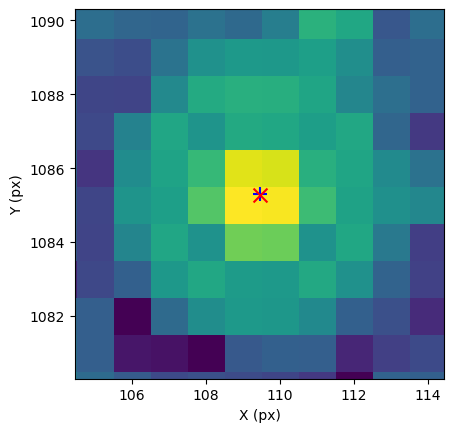

 star  284  dist= 0.002556661763476349


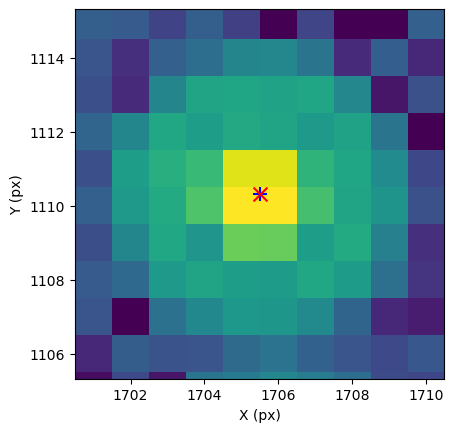

 star  295  dist= 0.002103894355172909


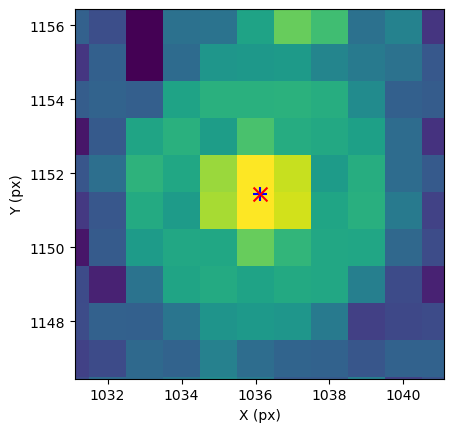

 star  312  dist= 0.0018154751034611838


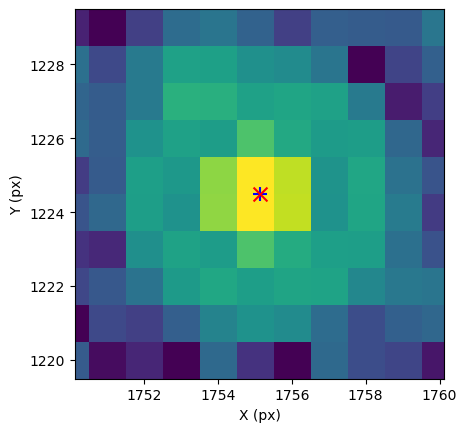

 star  357  dist= 0.002157366438082433


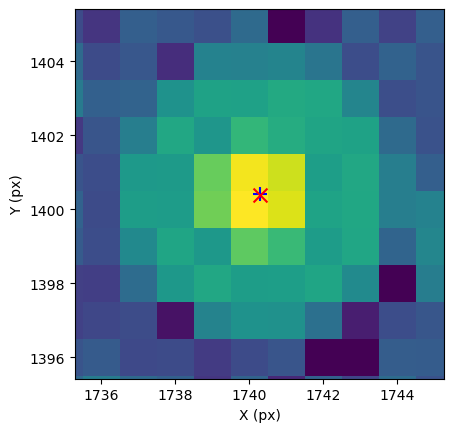

 star  360  dist= 0.0022870638885765593


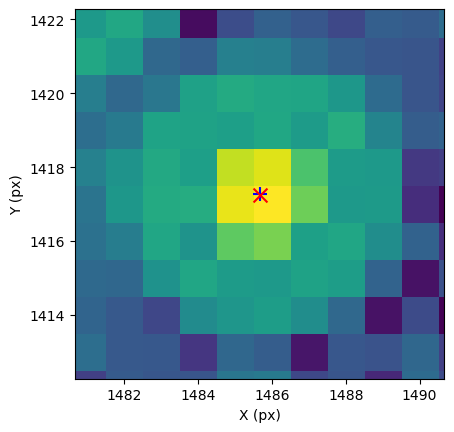

 star  364  dist= 0.0019198420386702243


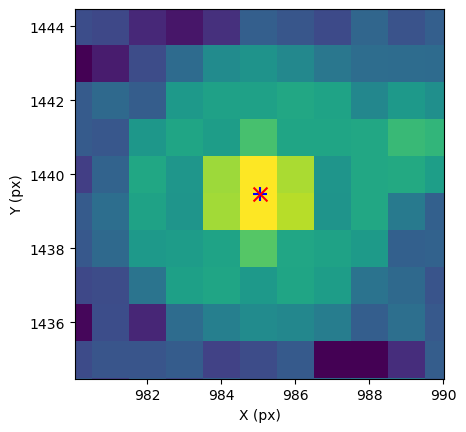

 star  390  dist= 0.0005921749074004824


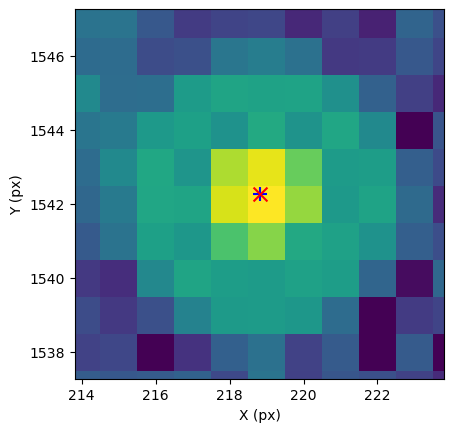

 star  406  dist= 0.002497718582707929


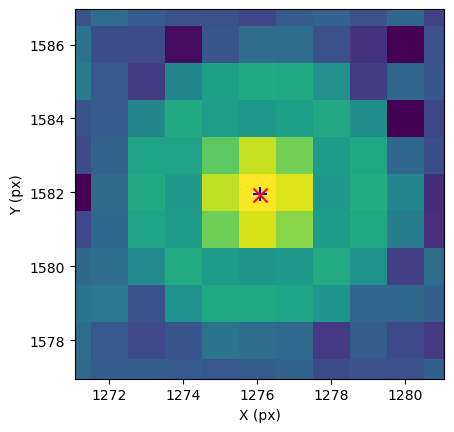

 star  458  dist= 0.0013814816663419761


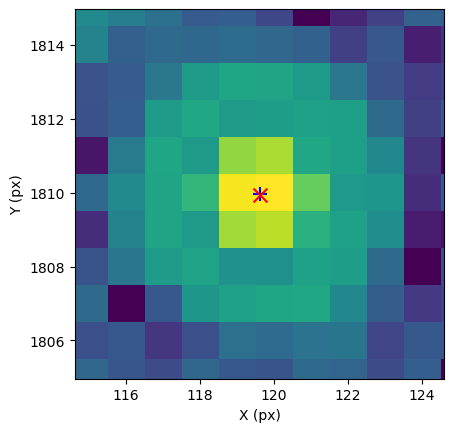

 star  466  dist= 0.0021835038295371025


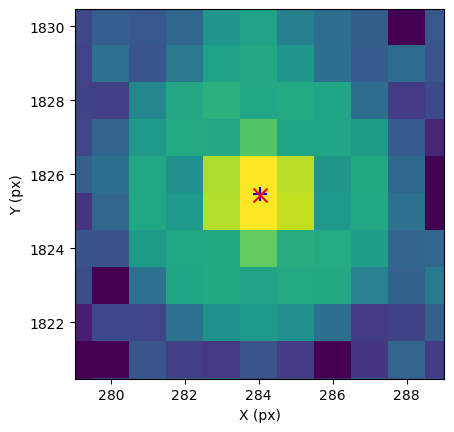

 star  471  dist= 0.0025482970590232157


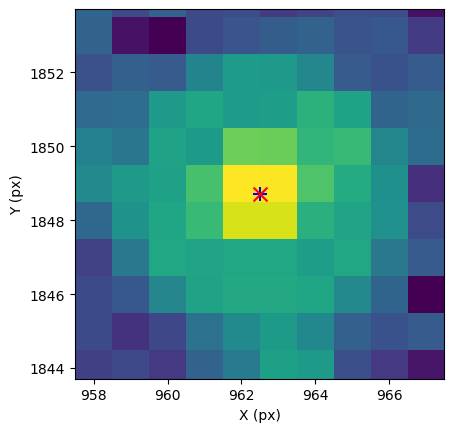

 star  474  dist= 0.0016328080383310073


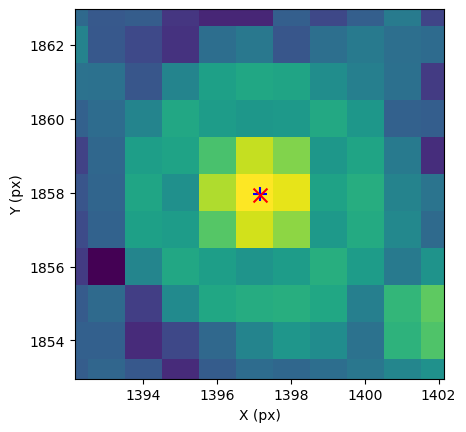

In [112]:
# good ones
print(' dx and dy mean = ', dx_mean, dy_mean)
for i in range(len(dist)):
    if dist[i]<0.003: 
        print(' star ', i, ' dist=', dist[i])
        plt.imshow(data, norm=norm, origin='lower', cmap='viridis')
        plt.scatter(xc_array[i,2], xc_array[i,3], s=100, c='blue', marker='+')
        plt.scatter(xc_array[i,0]+dx_mean, xc_array[i,1]+dx_mean, s=100, c='red', marker='x')
        plt.xlabel('X (px)')
        plt.ylabel('Y (px)')
        plt.xlim(xc_array[i,2]-5.0, xc_array[i,2]+5.0)
        plt.ylim(xc_array[i,3]-5.0,xc_array[i,3]+5.0)
        plt.show()

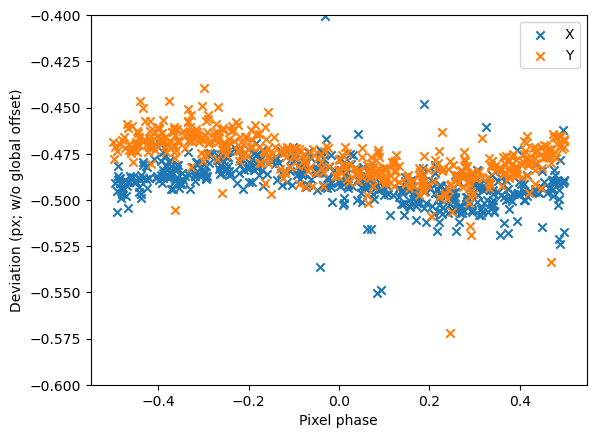

In [109]:
# Making pix-phase error data.
plt.scatter(xc_array[:,0]-(xc_array[:,0]+0.5).astype('int'), dx, marker='x', label='X')
plt.scatter(xc_array[:,1]-(xc_array[:,1]+0.5).astype('int'), dy, marker='x', label='Y')
#    plt.xlabel('$\Delta$x (px; w/o global offset)')
#    plt.ylabel('$\Delta$y (px; w/o global offset)')
#    plt.xlim([-0.03-0.98,0.03-0.98])
#    plt.ylim([-0.03-0.98,0.03-0.98])
#    plt.xlim([-0.5,0.5])
plt.ylim([-0.6,-0.4])
plt.xlabel('Pixel phase')
plt.ylabel('Deviation (px; w/o global offset)')
plt.legend()
plt.show()
    

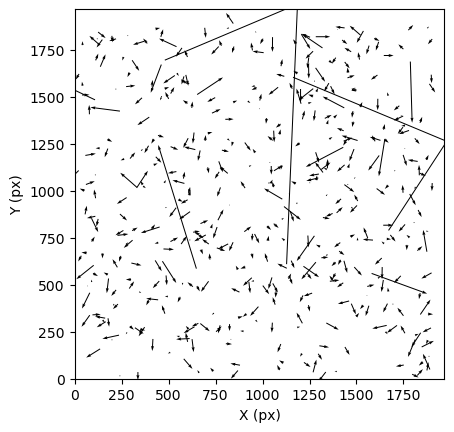

In [111]:
plt.axes().set_aspect('equal')
plt.quiver(xc_array[:,2], xc_array[:,3], dx0, dy0,
               angles='xy', scale_units='xy', scale=0.0003)
plt.xlabel('X (px)')
plt.ylabel('Y (px)')
plt.xlim([0, 1968])
plt.ylim([0, 1968])
plt.show()